# 101068721

# Can we predict if a song is danceable or not danceable?  

In this notebook, the dataset will be preprocessed and three classification algorithms will be used to classify each song into danceable and not danceable. The threashold chosen for danceability is 0.68, which is the average of 50th and 75th percentile of the dataset. 


###### Loading Data and general inspection
- creating new column "Danceable"
- Selecting columns needed for classification

###### Data Cleaning
- Remoing duplicate values 
- Missing value handling
- Removing outliers
- Imbalanced class check
- Categorical encoding
- Zero Variance and near zero variance
- Data tranformation 

###### Data Modelling and evaluation
- SVM without oversampling data
- Gini impurity value check 
- SMOTE oversampling 
- SVM with oversampled data 
- Data evaluation of training set (SVM)
- Hyperparamater tuning (SVM)
- Data evaluation of test set (SVM)
- Neural network model 
- Data evaluation of training set (NN)
- Data evaluation of test set (NN)
- Logistic regression model
- Data evaluation of training set (LR)
- Data evaluation of test set (LR)
- Comparison of accuracy scores

###### Data Visualisation 
- Danceability distribution 
- Learning curve
- ROC curve

# 1. Loading and inspecting data

Importing libraries 

In [1]:
import time
import warnings
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.models import Sequential 
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Removing warnings 
warnings.filterwarnings("ignore")

Importing the dataset

In [3]:
data = pd.read_csv("Spotify_Youtube.csv")

Checking the first 4 rows of the dataset so as to understand the columns. The transpose of data is taken so as to see the complete column list. 

In [4]:
data.head().T


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Artist,Gorillaz,Gorillaz,Gorillaz,Gorillaz,Gorillaz
Url_spotify,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...
Track,Feel Good Inc.,Rhinestone Eyes,New Gold (feat. Tame Impala and Bootie Brown),On Melancholy Hill,Clint Eastwood
Album,Demon Days,Plastic Beach,New Gold (feat. Tame Impala and Bootie Brown),Plastic Beach,Gorillaz
Album_type,album,album,single,album,album
Uri,spotify:track:0d28khcov6AiegSCpG5TuT,spotify:track:1foMv2HQwfQ2vntFf9HFeG,spotify:track:64dLd6rVqDLtkXFYrEUHIU,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,spotify:track:7yMiX7n9SBvadzox8T5jzT
Danceability,0.818,0.676,0.695,0.689,0.663
Energy,0.705,0.703,0.923,0.739,0.694
Key,6.0,8.0,1.0,2.0,10.0


Creating a new column danceable, by categorising the songs into d (danceable) and nd (not danceable) so that the machine learning model can be trained to classify based on this column. 

In [5]:
def fun(score):
    if score >= 0.68:
        return "d"
    else:
        return "nd"

data["Danceable"] = data["Danceability"].apply(fun)

Selecting the columns needed for predicting if a song is danceable or not. Only the song characteristics are chosen for analysis. The rest of the columns do not seem relevant to this analysis and hence have been dropped. 

In [6]:
data = data[["Energy", "Key", 
             "Loudness", "Speechiness", 
             "Acousticness", "Instrumentalness",
            "Liveness", "Valence", "Tempo", "Danceable"]]

Checking the value in each column to understand the data better. We see that there are some artists with less than 10 songs. Also, apart from artist, Key and danceable, all the other columns used in this analysis are continuous values.  

In [7]:
# Selecting columns from the dataset
columns = ["Energy", "Key", 
        "Loudness", "Speechiness", 
         "Acousticness", "Instrumentalness",
        "Liveness", "Valence", "Tempo", "Danceable"]

for i in columns:
    print(data[i].value_counts())

0.57200    60
0.71100    57
0.72000    57
0.78500    56
0.76800    56
           ..
0.03930     1
0.06020     1
0.00451     1
0.00647     1
0.99900     1
Name: Energy, Length: 1268, dtype: int64
0.0     2305
7.0     2252
1.0     2211
2.0     2021
9.0     1979
5.0     1731
11.0    1667
4.0     1515
8.0     1483
6.0     1443
10.0    1439
3.0      670
Name: Key, dtype: int64
-7.818    25
-7.768    21
-4.501    16
-6.887    15
-6.253    14
          ..
-7.934     1
-8.574     1
-9.118     1
-8.689     1
-3.055     1
Name: Loudness, Length: 9417, dtype: int64
0.0324    72
0.0305    68
0.0317    65
0.0288    65
0.0326    64
          ..
0.8660     1
0.7180     1
0.8690     1
0.9550     1
0.5340     1
Name: Speechiness, Length: 1303, dtype: int64
0.114000    50
0.161000    49
0.117000    45
0.105000    44
0.118000    41
            ..
0.005400     1
0.000055     1
0.000415     1
0.000757     1
0.000575     1
Name: Acousticness, Length: 3138, dtype: int64
0.000000    9391
0.000014      17
0.00

Checking the datatypes of each column to understand the dataset better, we can see that Danceable is the only one in object datatype, while all the other columns are float. 

In [8]:
data.dtypes

Energy              float64
Key                 float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
Danceable            object
dtype: object

# 2. Data Cleaning 

# 2.1 Duplicate values 

We check for dupicates and we see that there are only 1865 duplicates.

In [9]:
# Checking for duplicates
dups = data.duplicated()
data[dups]

,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Danceable
155,0.868,11.0,-5.282,0.0325,0.17600,0.000000,0.1840,0.483,131.971,d
248,0.617,2.0,-6.689,0.0345,0.05000,0.000059,0.0711,0.491,147.002,d
296,0.942,4.0,-2.273,0.1850,0.00789,0.000018,0.8340,0.543,126.017,nd
312,0.793,2.0,-4.254,0.1660,0.06030,0.000000,0.5820,0.751,107.045,d
333,0.858,1.0,-5.542,0.3110,0.12700,0.000000,0.3490,0.775,140.022,d
...,...,...,...,...,...,...,...,...,...,...
20672,0.643,10.0,-4.309,0.0442,0.18700,0.000000,0.1090,0.779,162.469,nd
20673,0.602,7.0,-4.629,0.0458,0.29900,0.000000,0.0716,0.756,157.643,nd
20675,0.517,0.0,-5.472,0.0673,0.52800,0.000000,0.1360,0.642,127.902,nd
20682,0.879,0.0,-4.218,0.0422,0.15800,0.001420,0.4390,0.341,114.993,d


 Dropping duplicate values as having duplicates in dataset can result in overfitting of data and inflated accuracy scores. 

In [10]:
data = data.drop_duplicates()

Checking for total duplicates and we can see that the duplicates are removed 

In [11]:
data.duplicated().sum()

0

# 2.2 Missing values  

Checking the missing values in each column, we see that there is only 1 missing value in Energy, Key, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Valence and Tempo. Since they are very few rows, they are deleted. 

In [12]:
data.isnull().sum()

Energy              1
Key                 1
Loudness            1
Speechiness         1
Acousticness        1
Instrumentalness    1
Liveness            1
Valence             1
Tempo               1
Danceable           0
dtype: int64

Replacing the missing values as NAN values so it is easier to be handled

In [13]:
data.replace("",np.nan)

,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Danceable
0,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.7720,138.559,d
1,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.8520,92.761,nd
2,0.923,1.0,-3.930,0.0522,0.042500,0.046900,0.1160,0.5510,108.014,d
3,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.5780,120.423,d
4,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.5250,167.953,nd
...,...,...,...,...,...,...,...,...,...,...
20713,0.926,5.0,-6.344,0.0328,0.448000,0.000000,0.0839,0.6580,90.002,nd
20714,0.936,4.0,-1.786,0.1370,0.028000,0.000000,0.0923,0.6570,174.869,nd
20715,0.830,4.0,-4.679,0.0647,0.024300,0.000000,0.1540,0.4190,168.388,nd
20716,0.767,9.0,-4.004,0.4190,0.356000,0.018400,0.1080,0.5390,155.378,nd


Dropping all the rows with missing value 

In [14]:
data = data.dropna(axis=0)

# 2.3 Ouliers

To see the statistic details of data, we use data. describe. Checking the statistic details, we see that the Energy is between 0 and 1, Key is between 0 and 11, Loudness is between -46 and 1, Speechinesss, Instrumentalness, Liveness and Valence is between 0 and 1 and Tempo is between 0 and 250. There are audio files with tempo as 0,valence as 0 and low Energy level etc. These seem to be outliers. 

In [15]:
data.describe()

,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,18852.000000,18852.000000,18852.000000,18852.000000,18852.000000,18852.000000,18852.000000,18852.000000,18852.000000
mean,0.634283,5.303575,-7.707274,0.095394,0.290207,0.056332,0.193054,0.530057,120.815429
std,0.215503,3.573991,4.605654,0.112921,0.288166,0.192755,0.167420,0.246628,29.615471
min,0.000020,0.000000,-46.251000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000
25%,0.502750,2.000000,-8.952250,0.035300,0.042000,0.000000,0.094100,0.338000,97.006500
50%,0.665000,5.000000,-6.589000,0.049800,0.188000,0.000003,0.125000,0.536000,119.976000
75%,0.800000,8.000000,-4.961000,0.101000,0.480000,0.000535,0.238000,0.728000,139.980000
max,1.000000,11.000000,0.920000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000


Due to lack of information on how spotify provides the scores for Tempo,Valence, Loudness etc, it is not possible deduce whether scores like Tempo, Variance etc being zero is error or genuine case by looking at the data or plotting boxplots hence LocalOutlierFactor is used to remove the outliers than manually removing the outliers. Checking outliers with local oulier factor, there are 66 values which are removed from the dataset. 

In [16]:
df = data[["Energy", "Key", 
       "Loudness", "Speechiness",
       "Acousticness", "Instrumentalness", 
       "Liveness", "Valence", "Tempo"]]

# Initialising LocalOutlierFactor
lof = LocalOutlierFactor()
# Fitting it onto the data
yhat = lof.fit_predict(df)
# Masking the values which are not outliers
mask = yhat != -1
# Counting the number of rows which are not ouliers
data[mask].count()

Energy              18786
Key                 18786
Loudness            18786
Speechiness         18786
Acousticness        18786
Instrumentalness    18786
Liveness            18786
Valence             18786
Tempo               18786
Danceable           18786
dtype: int64

Removing the outliers detected by LocalOutlerFactor 

In [17]:
data = data[mask]

# 2.4 Imbalanced dataset

Imbalance in dataset can impact the classification model. The model might underperform with the class with less samples. Checking the number of values in each class, we see that nd class has 11,462 and not d class has only 7324 values. The class imbalance is not a lot but based on the performance with the models in this notebook, resampling of data will be done. 

In [18]:
data["Danceable"].value_counts()

nd    11462
d      7324
Name: Danceable, dtype: int64

# 2.5 Category Encoding

The categorical columns needs to be encoded so that the model can train and make predictions on this dataset. We will be using label encoder to encode the danceability cateory as it is only two classes. d is encoded as 0 and nd is encoded as 1. 

In [19]:
# Initialising the label encoder
le = LabelEncoder()
# Transforming the column 
data["Danceable"] = le.fit_transform(data["Danceable"])

# 2.6 Single value columns

Single value columns do not add any value to predictive power of the model hence it can be removed. Checking the number of unique values in all columns, and we see that all the columns have more than one value and none of them have zero varience, hence none of the columns are dropped.

In [20]:
data.nunique()

Energy               1254
Key                    12
Loudness             9359
Speechiness          1301
Acousticness         3135
Instrumentalness     4004
Liveness             1535
Valence              1291
Tempo               14987
Danceable               2
dtype: int64

Checking if any column has near zero variance by checking if there are any columns with less than 1% unique values. Key column has less than 1%, this column is near to zero variance and can be removed.

In [21]:
for i in range(data.shape[1]):
# Finding number of unique values in each column 
    num = data.nunique() [i]
# Computing the percentage of unique values wrt the number of rows 
    percentage = float(num)/data.shape[0]*100
    if percentage <= 1:
        print(i, num, percentage)

1 12 0.06387735547748323
9 2 0.010646225912913872


Before removing the Key column, we compare the linear correlation of Key and other variables with danceability. Even though it has low variability, understanding if it has linear correlation or not will help in understanding if it will linearly impact the target variable. It also helps us in understanding the linear predictive power of the Key variable. Checking the linear correlation of variables with danceable column, we see that Key column has less linear correlation compared to other variables.

Text(0.5, 1.0, 'Pearson Correlation')

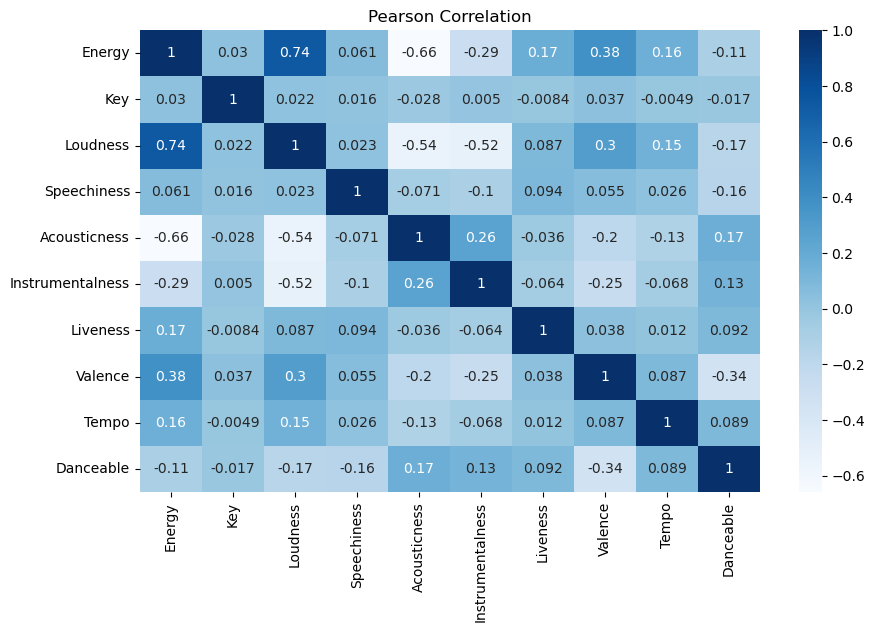

In [22]:
# Setting the size of the graph 
fig, ax = plt.subplots(figsize=(10,6))
# plotting the correlation matrix 
sns.heatmap(data.corr(method="pearson"), cmap="Blues", annot=True)
plt.title("Pearson Correlation")

Checking if Key column has a strong monotonic relationship with danceability using spearman correlation test. Since it has really less non linear relationship too, Key column can be removed. 

Text(0.5, 1.0, 'Spearman Correlation')

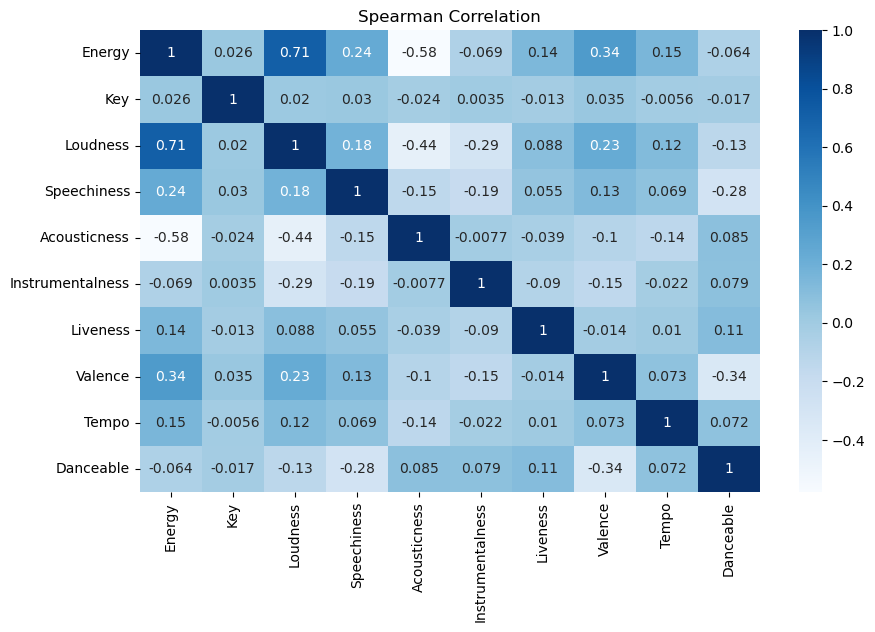

In [23]:
# Setting the size of the graph
fig, ax = plt.subplots(figsize=(10,6))
# Plotting the correlation matrix
sns.heatmap(data.corr(method="spearman"), cmap='Blues', annot=True)
plt.title("Spearman Correlation")

Dropping the Key column

In [24]:
data = data.drop("Key", axis=1)

# 2.7 Data transformation

Checking the statistical distribution of data to understand the ranges in which data is distributed. This helps in understanding whether to normalise or standardise data.

In [25]:
data.describe()

,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Danceable
count,18786.000000,18786.000000,18786.000000,18786.000000,18786.000000,18786.000000,18786.000000,18786.000000,18786.000000
mean,0.634502,-7.697578,0.095407,0.289829,0.055636,0.192835,0.530275,120.800348,0.610135
std,0.214674,4.556134,0.112974,0.287723,0.191344,0.167154,0.246271,29.385992,0.487732
min,0.000020,-46.251000,0.022000,0.000001,0.000000,0.014500,0.000000,38.137000,0.000000
25%,0.503000,-8.942250,0.035300,0.041900,0.000000,0.094100,0.339000,97.007250,0.000000
50%,0.665000,-6.589000,0.049800,0.188000,0.000003,0.125000,0.536000,119.975000,1.000000
75%,0.800000,-4.968250,0.101000,0.479750,0.000523,0.237000,0.728000,139.974000,1.000000
max,1.000000,-0.295000,0.964000,0.996000,0.995000,1.000000,0.993000,210.857000,1.000000


Checking the distribution of the data to understand whether to standardise or normalise the dataset. We see that only few have gaussian distribution hence not standardising the dataset. 

array([[<Axes: title={'center': 'Energy'}>,
        <Axes: title={'center': 'Loudness'}>,
        <Axes: title={'center': 'Speechiness'}>],
       [<Axes: title={'center': 'Acousticness'}>,
        <Axes: title={'center': 'Instrumentalness'}>,
        <Axes: title={'center': 'Liveness'}>],
       [<Axes: title={'center': 'Valence'}>,
        <Axes: title={'center': 'Tempo'}>,
        <Axes: title={'center': 'Danceable'}>]], dtype=object)

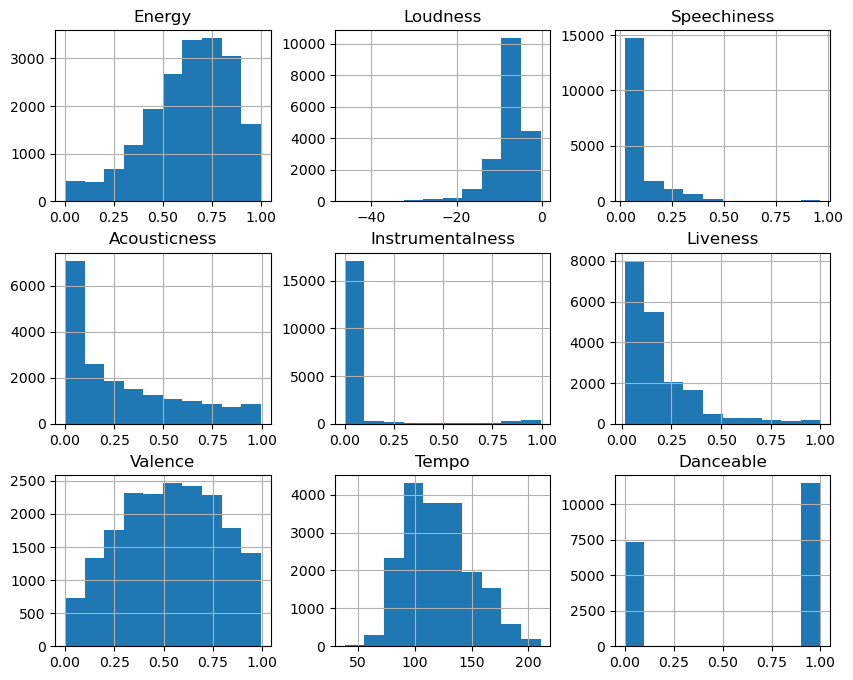

In [26]:
data.hist(figsize=(10,8))

Normalising is done to bring the values in each column to a specific range. Normalisation is done only to Loudness and Tempo columns as other columns  are in the range of 0 to 1 already.

In [27]:
# Selecting the columns which needs to be normalised 
scale = data.values[:,[1,7]]
trans = MinMaxScaler()
scale1 = trans.fit_transform(scale)
scaled = pd.DataFrame(scale1)

Resetting index before merging scaled data with original dataset as if the index are different for two datasets, the merging will create Nan values. 

In [28]:
data = data.reset_index(drop=True)

Merging Normalised data with the original dataset

In [29]:
data[["Loudness", "Tempo"]] = scaled[[ 0, 1]]

# 3. Data Modelling

# 3.1 Data splitting

In this section, the data will be split into test, train and validation sets. The dataset is divided into 80% training data and 20% test data. The training data will again be divided into 20% validation data and 80% training data. The dataset is split so as to use it for training, hyper parameter tuning and testing to see model's capability to generalise. 

In [30]:
np.random.seed(1)

# Setting input and target variables
X = data.drop("Danceable", axis=1)
y = data["Danceable"]

# Splitting the data into training data and 20% test data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Splitting training data again into validation and training data 
X_train_check, X_val, y_train_check, y_val = train_test_split(X_train_full, y_train_full, test_size =0.20, random_state=3)

#Checking the length of training, test and validation set
print ("Length of dataset:", len(X))
print ("Length of training set:", len(X_train_check))
print ("Length of validation set:", len(X_val))
print ("Lenhth of test set:", len(X_test))

Length of dataset: 18786
Length of training set: 12022
Length of validation set: 3006
Lenhth of test set: 3758


# 3.2 Support Vector Machine 

The model will be first trained on the training data and then the the model will be hyper parameter tuned on the validation set and then tested on the validation set. The kernel function is chosen as linear and c is the regularisation parameter. A lower value of c allows few misclassifications to get a smoother decision boundary between two classes. We see that the model is performing badly with classifying class 0 compared to class 1.

In [31]:
# Creating SVM classifier
svm_classsifier = SVC(kernel="linear", C=0.01)

# Fitting the classifier model onto the training data 
svm_classsifier.fit(X_train_check, y_train_check)

# Using model to make predictions 
y_pred_train_check = svm_classsifier.predict(X_test)


# 3.2.1 Training Data Evualuation 

In [32]:
# Checking the accuracy, precision, recall and f1_score of the model 
print("Accuracy :",accuracy_score(y_test, y_pred_train_check))
print(classification_report(y_test, y_pred_train_check))

Accuracy : 0.699308142629058
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1427
           1       0.71      0.87      0.78      2331

    accuracy                           0.70      3758
   macro avg       0.69      0.65      0.65      3758
weighted avg       0.69      0.70      0.68      3758



Checking the size of both classes in training set to see if it needs to be balanced using oversamploing techniques. After checking we see that there is an imbalance.

In [33]:
y_train_check.value_counts()

1    7278
0    4744
Name: Danceable, dtype: int64

Gini impurity tells us if a label is chosen in random, the probability of labelling it wrong if it was randomly labelled. Gini impurity score of 0 shows the values are of only one class and score of 1 shows that the classes are evenly distributed. Calculating the gini impurity of the training set we see that the gini impurity score is not 0.5 which happens when it is a balanced data set (1-(1/2)). The dataset has a score of around 0.48 which shows the imbalance.

In [34]:
classes = y_train_check.value_counts()

# Finding each class values 
class_0 = classes[0]
class_1 = classes[1]

# Calculating sum of both classes
both_classes = class_0 + class_1

# Finding the probability of both classes square
p = np.square(class_0/both_classes) + np.square(class_1/both_classes)

# Calculating gini score
gini_score = 1-p 

print("Gini impurity score:",gini_score)

Gini impurity score: 0.47778584600665985


The imbalance might result in model performing badly with class with lesser rows. Hence we use SMOTE to oversample the 0 class which has lesser samples. 

In [35]:
# Unistaling current version of scikit-learn as it does not work with imblearn 
#!pip uninstall scikit-learn --yes
#!pip uninstall imblearn --yes
# Reinstalling version 1.2.2 of scikit learn
# !pip install scikit-learn==1.2.2
# !pip install imblearn

Using SMOTE to over sample so that both the classes have balanced number of rows in training set as the model will be trained using training set. 

In [36]:
smote = SMOTE(random_state=3)
#Applying SMOTE to training data 
X_train, y_train = smote.fit_resample(X_train_check, y_train_check)

Checking the number of each classes in training set, we can see that it is balanced now. 

In [37]:
y_train.value_counts()

1    7278
0    7278
Name: Danceable, dtype: int64

# 3.2.2 Support Vector Machine( after Oversampling)

Now both the classes are balanced and the SVM classifier is intiated and predictions are made.

In [38]:
# Creating SVM classifier
svm_classsifier = SVC(kernel="linear", C=0.01)

# Fitting the classifier model onto the training data 
svm_classsifier.fit(X_train, y_train)

SVC(C=0.01, kernel='linear')

# 3.2.3 Training Data Evaluation (after oversampling)

Now checking how the support vector model used above performs with new training data which has balanced classes, even though the overall accuracy has gone down a bit, there is good amount of performance improvement in model on class 0.

In [39]:
# Using model to make predictions 
y_pred_train_svm = svm_classsifier.predict(X_train)
# Checking the accuracy, precision, recall and f1_score of the model 
print("Accuracy :",accuracy_score(y_train, y_pred_train_svm))
print(classification_report(y_train, y_pred_train_svm))

Accuracy : 0.6867958230283044
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      7278
           1       0.71      0.63      0.67      7278

    accuracy                           0.69     14556
   macro avg       0.69      0.69      0.69     14556
weighted avg       0.69      0.69      0.69     14556



To find the parameters of svm that provides best performance, hyperparameter tuning is done using GridSearchCV. Before GridSearchCV, the parameters of SVM is checked. 

In [40]:
svm_classsifier.get_params()

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# 3.2.4 Hyperparameter tuning SVM

The parameters C, kernel and gamma are parameters that are going to be used in hyperparameter tuning in grid search. Three C and gamma values are chosen and three kernel functions are chosen. The grid search object is trained on validation set and is used to decide the best parameters. The best model with best parameters are used to train on training data and the predictions are made on test data which is an unseen data for the model. The best parameters chosen are C=10, gamma= 1 and kernel= rbf. Values above 10 are not chosen for c and gamma as higher values tends to cause overfitting of data. The scoring method chosen for optimisation is precision, so that the hyperparameters are chosen so that there are less false positives or less non danceable songs which are classified as danceable. It will result in less recall score because of the trade off between precision and recall.  

In [41]:
# Selecting paramaters and values that needs to be checked
param_grid = { "C" : [0.1, 1, 10],
             "kernel" : ["rbf", "linear", "poly"],
             "gamma" : [0.01, 0.1, 1]}

for i in tqdm(range(100)):
# Creating grid_search object with 5 fold cross validation
    grid_search = GridSearchCV(svm_classsifier, param_grid,cv=5, scoring="precision")
# Fitting the grid_search object on the validation set 
    grid_search.fit(X_val,y_val)
# Adding a sleep time to reduce the strain on the CPU, while running the for loop
    time.sleep(0.0000001)

# Finding the best estimator and parameters
best_mod = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_mod, best_params)

# Fitting the best model onto training data
best_mod.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

SVC(C=10, gamma=1) {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


SVC(C=10, gamma=1)

# 3.2.5 Test Data Evaluation

The model generalises well too compared to the training data. The model is also not overfitting on the training data. 

In [42]:
# Predicting the classes in test data 
y_pred_test_svm = best_mod.predict(X_test)

# Checking the accuracy, precision, recall and f1_score of the model 
print("Accuracy of test set:",accuracy_score(y_test, y_pred_test_svm))
print(classification_report(y_test, y_pred_test_svm))

Accuracy of test set: 0.7514635444385311
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1427
           1       0.84      0.74      0.79      2331

    accuracy                           0.75      3758
   macro avg       0.74      0.76      0.74      3758
weighted avg       0.77      0.75      0.75      3758



# 3.3 Neural Network

In this section, a neural network will be used to classify the dataset into 0 and 1. There are two hidden layers with relu as activation function. A dropout layer is also added to avoid the model overfitting. The output layer is sigmoid and the loss function used is binary cross entropy as it is a binary classification problem. 

In [43]:
# Creating the model 
nn_classifier = Sequential()

# Creating input layer 
nn_classifier.add(Dense(64, input_shape=(8,), activation="relu"))
# Creating another activation layer 
nn_classifier.add(Dense(32, activation ="relu"))
# Creating Dropout layer to avoid overfitting
nn_classifier.add(Dropout(0.4))
# Creating output layer
nn_classifier.add(Dense(1, activation ="sigmoid"))


# Compiling the model 
nn_classifier.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy"])

# Fitting the model on training data 
nn_classifier.fit(X_train, y_train, epochs= 20)

Epoch 1/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - accuracy: 0.6405 - loss: 0.6325
Epoch 2/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.7208 - loss: 0.5643
Epoch 3/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.7268 - loss: 0.5463
Epoch 4/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.7397 - loss: 0.5251
Epoch 5/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.7597 - loss: 0.5069
Epoch 6/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.7582 - loss: 0.5063
Epoch 7/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.7635 - loss: 0.4932
Epoch 8/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - accuracy: 0.7716 - loss: 0.4875
Epoch 9/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.7681 - loss: 0.4835
Epoch 10/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.7673 - loss: 0.4862
Epoch 11/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.7773 - loss: 0.4780
Epoch 12/20
455/455 ━━━━━━━━━━

# 3.3.1 Data Evaluation on training data

Overall accuracy on the test data is around 78% and the 0 class has better recall score while class 1 has better precision score. 

In [44]:
# Making predictions on training data and rounding the predicted probabilities
y_pred_train_nn = np.round(nn_classifier.predict(X_train)).astype(int)

print("accuracy score for training", accuracy_score(y_train, y_pred_train_nn))
print(classification_report(y_train, y_pred_train_nn))

455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
accuracy score for training 0.7832508931025007
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      7278
           1       0.78      0.79      0.79      7278

    accuracy                           0.78     14556
   macro avg       0.78      0.78      0.78     14556
weighted avg       0.78      0.78      0.78     14556



# 3.3.2 Data Evaluation on test data

To check whether the training data is overfitting, the model is used to predict the values in test set. The accuracy score has dropped only from 0.75 to 0.73 to test set which shows the model is not overfitting. 

In [45]:
# Making predictions on test data and rounding the predicted probabilities
y_pred_test_nn = np.round(nn_classifier.predict(X_test)).astype(int)

print("accuracy score on test data", accuracy_score(y_test, y_pred_test_nn))
print(classification_report(y_test, y_pred_test_nn))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
accuracy score on test data 0.7645023948908994
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1427
           1       0.83      0.79      0.81      2331

    accuracy                           0.76      3758
   macro avg       0.75      0.76      0.75      3758
weighted avg       0.77      0.76      0.77      3758



# 3.4 Logistic Regression

A logistic regression model is used to check how well it performs on the dataset. The logistic regression's computational complexity is less compared to both the neural network and svm.

In [46]:
# Creating and logistic regression classifier model 
lr_classifier = LogisticRegression()

# Fitting the model onto the training data 
lr_classifier.fit(X_train, y_train)

LogisticRegression()

# 3.4.1 Data Evaluation on training data

Predicting on the train data, the model has average performance on both the classes. The overall accuracy on train data is around 0.70.  

In [47]:
# Using model to make predictions 
y_pred_train_lr = lr_classifier.predict(X_train)
# Checking the accuracy, precision, recall and f1_score of the model 
print("Accuracy :",accuracy_score(y_train, y_pred_train_lr))
print(classification_report(y_train, y_pred_train_lr))

Accuracy : 0.7088485847760374
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      7278
           1       0.72      0.69      0.70      7278

    accuracy                           0.71     14556
   macro avg       0.71      0.71      0.71     14556
weighted avg       0.71      0.71      0.71     14556



Finding all the parameters that the logistic regression model has before hyperparameter tuning

In [48]:
lr_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# 3.4.2 Hyperparamater tuning Logistic Regression model

The model is hyperparameter tuned using GridSearchCV on validation set since the train set is big and will take more computational power. The penality and C values are hyperparameter tuned. Penality specifies the type of regularisation to be used. Regularisation helps in reducing overfitting and C controls the strength of regularisation. 

In [49]:
param_grid = { "penalty" : ["l1", "l2", "elasticnet"],
             "C": [0.001, 0.1, 1, 10, 100]}

for i in tqdm(range(100)):
# Creating grid_search object with 5 fold cross validation
    grid_search = GridSearchCV(lr_classifier, param_grid,cv=5, scoring="precision")
# Fitting the grid_search object on the validation set 
    grid_search.fit(X_val,y_val)
# Adding a sleep time to reduce the strain on the CPU, while running the for loop
    time.sleep(0.0000001)

# Finding the best estimator and parameters
best_mod = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_mod, best_params)

# Fitting the best model onto training data
best_mod.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

LogisticRegression(C=10) {'C': 10, 'penalty': 'l2'}


LogisticRegression(C=10)

# 3.4.3 Data Evaluation on test set

In [50]:
# Predicting the classes in test data 
y_pred_test_lr = best_mod.predict(X_test)

# Checking the accuracy, precision, recall and f1_score of the model 
print("Accuracy of test set:",accuracy_score(y_test, y_pred_test_lr))
print(classification_report(y_test, y_pred_test_lr))

Accuracy of test set: 0.6937200638637573
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1427
           1       0.79      0.69      0.74      2331

    accuracy                           0.69      3758
   macro avg       0.69      0.70      0.69      3758
weighted avg       0.71      0.69      0.70      3758



# 3.5 Comparison of models

Comparing the accuracy value for both the SVM and the neural network for both test and train data,  it can be seen that both the models has similar accuracy but the logistic regression model performs badly compared to the svm and neural network. 

In [51]:
# Creating a table of accuracy scores of both the models
comparison_df = pd.DataFrame({
    "models": ["SVM",
              "Neural Network",
              "Logistic Regression"],
    "Train set acccuracy" : [accuracy_score(y_train, y_pred_train_svm),
                           accuracy_score(y_train, y_pred_train_nn),
                            accuracy_score(y_train, y_pred_train_lr)],
    "Test set accuracy": [accuracy_score(y_test, y_pred_test_svm),
                           accuracy_score(y_test, y_pred_test_nn),
                         accuracy_score(y_test, y_pred_test_lr)]})

comparison_df

,models,Train set acccuracy,Test set accuracy
0,SVM,0.686796,0.751464
1,Neural Network,0.783251,0.764502
2,Logistic Regression,0.708849,0.693720


# 4. Data Visualisation

# 4.1 Danceability distribution

Importing the dataset again since Danceability column is deleted from the data dataframe

In [52]:
plot_data = pd.read_csv("Spotify_Youtube.csv")

Plotting the distribution of song based on Danceability column and Tempo. Green shows the Danceable songs and red shows the not danceable songs. Tempo was used because index was not related to the danceability and it was unable to show the distribution on danceability due to the number of rows. To see the dance distrubition tempo was selected as the variable to plot against the danceability values as tempo is related to danceability and tempo has a distribution from 0 to 250 which could show the distrbution of danceability in a better way. 

<Axes: xlabel='Danceability', ylabel='Tempo'>

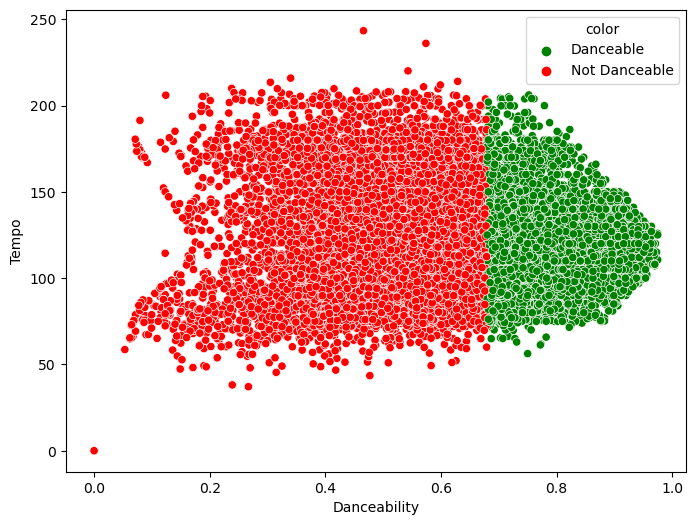

In [53]:
plot_data["color"]= np.where(plot_data["Danceability"]>=0.68,"Danceable","Not Danceable")

plt.figure(figsize=(8,6))
sns.scatterplot(data =plot_data, 
                x =plot_data["Danceability"],
                y= plot_data["Tempo"], 
                hue="color", 
                palette={"Danceable":"green",
                         "Not Danceable":"red"})

# 4.2 Learning curve 

In [54]:
train_sizes, train_scores, test_scores = learning_curve(svm_classsifier,
                                                        X_train, y_train,
                                                        cv=5,
                                                        scoring="accuracy",
                                                        train_sizes=np.linspace(0.1,1,5))
# Calculating the mean of test and train data
train_mean_svm = train_scores.mean(axis=1)
test_mean_svm = test_scores.mean(axis=1)

train_sizes, train_scores, test_scores = learning_curve(lr_classifier,
                                                        X_train, y_train,
                                                        cv=5,
                                                        scoring="accuracy",
                                                        train_sizes=np.linspace(0.1,1,5))
# Calculating the mean of test and train data on lr model
train_mean_lr = train_scores.mean(axis=1)
test_mean_lr = test_scores.mean(axis=1)


history = nn_classifier.fit(X_train,
                            y_train, 
                            validation_data=(X_test, y_test),
                            epochs=20,
                            verbose=0)

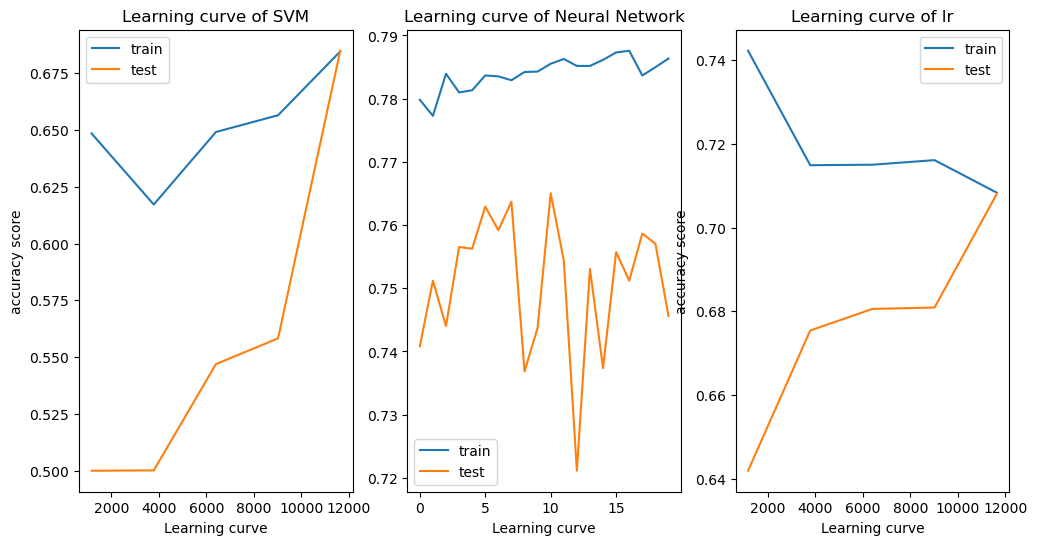

In [55]:
fig, axes = plt.subplots(1,3, figsize=(12,6))

# Plotting learning curve for SVM 
axes[0].plot(train_sizes, train_mean_svm, label="train")
axes[0].plot(train_sizes, test_mean_svm, label="test")
axes[0].set_title("Learning curve of SVM")
axes[0].set_ylabel("accuracy score")
axes[0].set_xlabel("Learning curve")
axes[0].legend(loc="best")


# Plotting learning curve of train and test set of neural network over 20 epochs
axes[1].plot(history.history["accuracy"], label="train")
axes[1].plot(history.history["val_accuracy"], label="test")
axes[1].legend(loc="best")
axes[1].set_title("Learning curve of Neural Network")
axes[1].set_xlabel("Learning curve")

# Plotting learning curve for logistic regression
axes[2].plot(train_sizes, train_mean_lr, label="train")
axes[2].plot(train_sizes, test_mean_lr, label="test")
axes[2].set_title("Learning curve of lr")
axes[2].set_ylabel("accuracy score")
axes[2].set_xlabel("Learning curve")
axes[2].legend(loc="best")

The learning curves of svm show that the model performed badly and the variability with train set learning curve was high. But the difference reduced as the model got more test data. In the neural network, over 20 epochs, the learning curve is highly oscillatory but the variability between test and train learning curve is not a lot. The learning curve of logistic regression shows that over the time the model performs well on test data. All the graphs show that the models are not overfitting.

# 4.3 ROC Curve

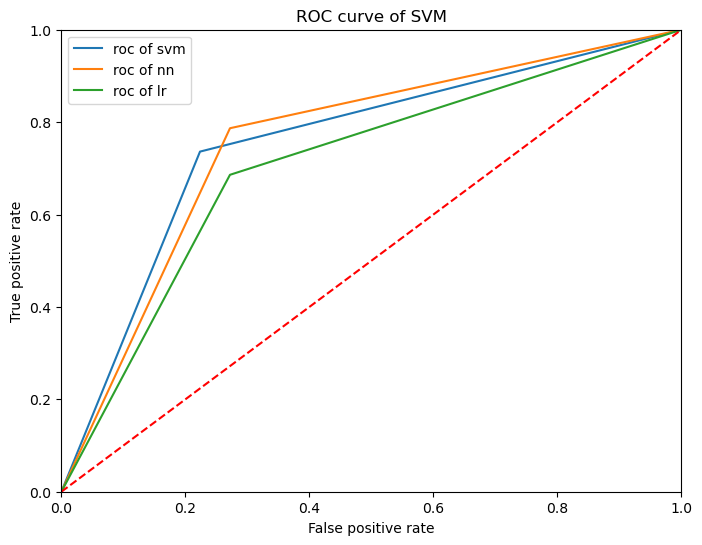

In [56]:
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_pred_test_svm)
fpr_nn, tpr_nn, thresholds_nn = metrics.roc_curve(y_test, y_pred_test_nn)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred_test_lr)


plt.subplots(figsize=(8,6))
# Plotting learning curve for SVM 
plt.plot(fpr_svm, tpr_svm, label="roc of svm")
# Plotting roc for neural network
plt.plot(fpr_nn, tpr_nn, label="roc of nn")
# Plotting roc for logistic regression
plt.plot(fpr_nn, tpr_lr, label="roc of lr")
# Drawing diagonal line
plt.plot([0,1],[0,1], color="red", linestyle="--")
# Setting limits for x and y axis
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title("ROC curve of SVM")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend(loc="best")
plt.show()

The ROC curves of both svm, logistic regression and neural network are above the diagonal line which indicates that that the chances are better than random classifier and roc of both classifiers are bowing mostly towards the top left indicating that the  the positive rates are more and false positive rates are comparitevly lesser. SVM model has lesser false positive rates compared to neural network model and logistic regression.